Pinksy Rinzel One Compartment Condensed Code

    of finite elements specified in apply. The larger number of finite
    elements will be used.
Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    44000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16001

Total number of variables............................:    12006
                     variables with only lower bounds:        0
                variables with lo

<IPython.core.display.Javascript object>


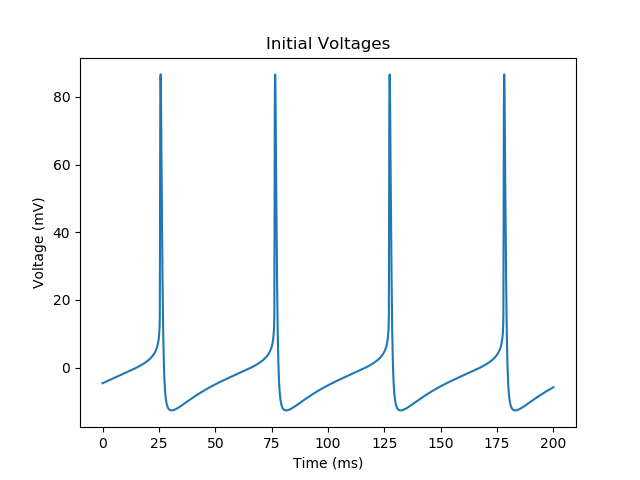

<IPython.core.display.Javascript object>


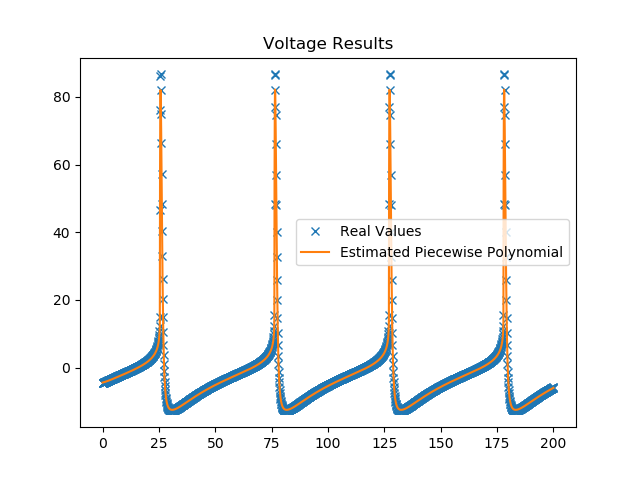

-4.418411687115308
Results: gNa = 31.488, gKDR = 15.647, gL = 0.094
Absolute Error = 1003.335, Relative Error = 0.502
Runtime = 54.467 s
Info: Time Steps = 2001, Measured Voltages = 2000


In [2]:
## Necesary Imports ##

#Pyomo and Pyomo.dae
from pyomo.environ import *
from pyomo.dae import *

#Numpy and Scipy for importing and working with model data.
import numpy as np
import scipy.io as spio

#Matplotlib for plotting results.
%matplotlib notebook
import matplotlib.pyplot as plt 

#Random for creating noisy data.
import random

#Timeit for runtime.
import timeit
start = timeit.default_timer()

## Initializing Data ##

#data created in MATLAB using time step of 0.05 (for 200 ms) 
#and runge-kutta 4th order method for approximating steps on pr model
#4001 times, voltages
#note: peak times = [25.95, 77.2, 128.45, 179.7], peak indices = [519, 1544, 2569, 3594]

treal = spio.loadmat('Data/t_real.mat')
treal = [float(x) for x in treal['treal']]
treal = treal[0:4000]
trlen = len(treal)

#how many time steps we will use
tstep = 2 #every nth time
trealcut = [treal[i] for i in range(0, trlen, tstep)] #times that we will include in discretization
trclen = len(trealcut)

#Voltages
#vreal = spio.loadmat('Data/v_real.mat')
vreal = spio.loadmat('Data/vreal_be.mat')
vreal = [float(x) for x in vreal['vreal_be']]
vreal = vreal[0:4000]
vrlen = len(vreal)

#how many measured Voltages do we have (artificically reducing number of voltages)

#first we reduce number of voltages to be equal to length of our discretized set
#since we can't check at time that aren't in our discretized set
vrealcut = [vreal[i] for i in range(0, vrlen, tstep)]

#now we artifically get rid of some of the measured values
vstep = 1 #every nth voltage from vrealcut
vrealm = [vrealcut[i] for i in range(0,len(vrealcut) , vstep)]

#times at which we have measured voltages
vmeaslen = len(vrealm)
vtimes = [trealcut[i] for i in range(0, trclen, vstep)]

#adding noise to data
#vreal = [v + (0.5-(random.random()*1.0)) for v in vreal]

#data to test against

#vtest = spio.loadmat('Data/vtest.mat')
#vtest = [float(x) for x in vtest['vtest']]
#vtestcut = [vtest[i] for i in range(0, vrlen, tstep)]
#vtestm = [vtestcut[i] for i in range(0,len(vtestcut) , vstep)]


#hreal and nreal for possible help in computation
hreal = spio.loadmat('Data/hreal.mat')
hreal = [float(x) for x in hreal['hreal']]
hreal = hreal[0:4000]
hrealcut = [hreal[i] for i in range(0, vrlen, tstep)]
hrealm = [hrealcut[i] for i in range(0,len(hrealcut) , vstep)]

nreal = spio.loadmat('Data/nreal.mat')
nreal = [float(x) for x in nreal['nreal']]
nreal = nreal[0:4000]
nrealcut = [nreal[i] for i in range(0, vrlen, tstep)]
nrealm = [nrealcut[i] for i in range(0,len(nrealcut) , vstep)]

#breakpoints found using ppfit to fit piecewise polynomial to data w/o ODEs
#breaks_n uses n linear polynomials to estimate data w/o ODE, breaks is the breakpoints used in this estimation
#this is a possible second option to use as times for discretization
breaks = spio.loadmat('Data/breaks2000.mat')
breaks = [round(2*x,1) / 2 for x in breaks['breaks'][0]]
#rounding 2*x then dividing by 2 vs just rounding x in order to capture .05 second steps vs 0.1 second steps

## Creating Model ##

model = ConcreteModel()

#Time
model.t = ContinuousSet(bounds=(0,200), initialize=trealcut) #200 ms, initializing times for discretization

#Constants
Cm=3 # Membrane Capcitance uF/cm^2
dt=0.05 # Time Step ms
p = 0.5 #Fraction of cable length assigned to soma (1-p for dendtrite)
Is=0.25 #External Current Applied #can be -0.5 for simpler model, can vary this as well and see what happens
VNa=120 # mv Na reversal potential
VK=-15 # mv K reversal potential
VL=0 # mv Leakage reversal potential

#Variables

#Parameters that we are solving for
#We can fix zero, one, or several of the parameters, and solve for the other(s)
#note: Initializing gNa or gL doesn't seem to matter while initializing gKDR seems to make a big difference
model.gNa = Var(bounds=(1.0,50.0), initialize=25.0) # mS/cm^2 Na max conductance (30 real)
#model.gNa = Param(initialize=30.0)
model.gKDR = Var(bounds=(1.0,50.0), initialize=25.0) # mS/cm^2 K max conductance (15 real)
#model.gKDR = Param(initialize=15.0)
model.gL = Var(within=NonNegativeReals, bounds=(0,2), initialize=0.5) # mS/cm^2 Leakage max conductance (0.1 real)
#model.gL = Param(initialize=0.1)

#Vs, h, and n, initializing each to be their value at t=0.
model.Vs = Var(model.t, bounds=(-15,120), initialize=-4.6)
model.h = Var(model.t, bounds=(0,1), initialize=0.001)
model.n = Var(model.t, bounds=(0,1), initialize=0.999)

#Necesary Funcions

#forward rate constant for fast sodium
def am(v):
    return 0.32*(13.1-v)/(exp((13.1-v)/4)-1)

#backward rate constant for fast sodium
def bm(v):
    return 0.28*(v-40.1)/(exp((v-40.1)/5)-1)

#forward rate constant for DR activation
def an(v):
    return 0.016*(35.1-v)/(exp((35.1-v)/5)-1)

#backward rate constant for DR activation
def bn(v):
    return 0.25*exp(0.5-0.025*v)

#forward rate constant for sodium inactivation
def ah(v):
    return 0.128*exp((17-v)/18)

#backward rate constant for sodium inactivation
def bh(v):
    return 4/(1+exp((40-v)/5))


#somatic leak current
def Ils(t):
    return model.gL*(model.Vs[t]-VL)

#steady-state sodium activation (instantaneous)
def minf(t):
    return am(model.Vs[t])/(am(model.Vs[t])+bm(model.Vs[t]))

#sodium current (y(2) is h, inactivation of sodium current)
def INa(t):
    return model.gNa*(minf(t)**2)*model.h[t]*(model.Vs[t]-VNa)

#delayed rectifier current (y(3) is n, activation of DR)
def IKDR(t):
    return model.gKDR*model.n[t]*(model.Vs[t]-VK)

#Initial Conditions
#note: not using Vs[0] seems to actually help the solver while
#not using h[0] and n[0] doesnt't seem to make a big difference.
def condi(model):
    #yield model.Vs[0] == vreal[0] # Initial Membrane voltage
    #yield model.h[0] == hreal[0] # Initial h-value
    #yield model.n[0] == nreal[0] # Initial n-value
    yield ConstraintList.End
model.cond = ConstraintList(rule = condi)

#Defining derrivatives
model.dVsdt = DerivativeVar(model.Vs, wrt=model.t)
model.dhdt = DerivativeVar(model.h, wrt=model.t)
model.dndt = DerivativeVar(model.n, wrt=model.t)


#ODE's
#Defining system governing ODE's as constraints on the model
#note: not applying ODE at t=0 (or t=200) can be beneficial here (and in pyomo in general)
def _ode1(mo, t):
    if t == 0:
        return Constraint.Skip
    return mo.dVsdt[t] == (-Ils(t) - INa(t) - IKDR(t) + Is/p)/Cm
model.ode1 = Constraint(model.t, rule=_ode1)

def _ode2(mo, t):
    if t == 0:
        return Constraint.Skip
    return mo.dhdt[t] ==  ah(mo.Vs[t])*(1-mo.h[t])-bh(mo.Vs[t])*mo.h[t]
model.ode2 = Constraint(model.t, rule=_ode2)

def _ode3(mo, t):
    if t == 0:
        return Constraint.Skip
    return mo.dndt[t] == an(mo.Vs[t])*(1-mo.n[t])-bn(mo.Vs[t])*mo.n[t]
model.ode3 = Constraint(model.t, rule=_ode3)

#Discretization, using Backward Euler
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(model,nfe=1, scheme='BACKWARD') 
#nfe value will be overridden when len(trealcut) > nfe which it currently is.

#Objective
fe = model.t.get_finite_elements()
felen = len(fe)

def objfun(mo):
    myobj = 0
    for ft in fe:
        if ft in vtimes:
                idx = vtimes.index(ft)
                #sum of error squared at each test point
                myobj += ((model.Vs[ft] - vrealm[idx])**2) #maybe use absolute value here too
    #myobj += 10000000*((model.Vs[0]-vrealm[0])**2)
    return myobj
model.obj = Objective(rule = objfun)


# Initializng Model (Warm Sart)

vistep = 1 #change this value if you only want to initialize every nth measured voltage to be exact
#voltages to be exactly initialized
vinit = [vrealm[i] for i in range(0,vmeaslen,vistep)]
vitimes = [vtimes[i] for i in range(0,vmeaslen,vistep)]

hinit = [hrealm[i] for i in range(0,vmeaslen,vistep)]
ninit = [nrealm[i] for i in range(0,vmeaslen,vistep)]
#useful for intializing voltages in between two measured voltages
vnext = vinit[0]
vtnext = vitimes[0]

hnext = hinit[0]
nnext = ninit[0]

fidxf = fe.index(vitimes[-1])
fecut = fe[0:]

for ft in fe:
    if ft == vtnext:
        vlast = vnext
        hlast = hnext
        nlast = nnext
        
        vtlast = vtnext
        
        model.Vs[ft].value = vlast
        #model.h[ft].value = hlast
        #model.n[ft].value = nlast
        
        vinit = vinit[1:]
        hinit = hinit[1:]
        ninit = ninit[1:]
        
        vitimes = vitimes[1:]
        if vinit: #check if we have used all measured values
            vnext = vinit[0]
            hnext = hinit[0]
            nnext = ninit[0]
            
            vtnext = vitimes[0]
            curder = (vnext - vlast) / (vtnext - vtlast)
            curderh = (hnext - hlast) / (vtnext - vtlast)
            curdern = (nnext - nlast) / (vtnext - vtlast)
        else:
            vtnext = 0
            
    else:
        #initializing in between voltages as on line between two measured voltages
        model.Vs[ft].value = vlast + (ft-vtlast)*curder
        #model.h[ft].value = hlast + (ft-vtlast)*curderh
        #model.n[ft].value = nlast + (ft-vtlast)*curdern
        
        #this is for initializing in between voltages as equal to last measured voltage
        #model.Vs[tn].value = vlast

#for plotting initailized Vs
    vi = []
    hi = []
    ni = []
    tf = []
    for ti in fe:
        vi.append(value(model.Vs[ti]))
        hi.append(value(model.h[ti]))
        ni.append(value(model.n[ti]))
        tf.append(ti)
        
# Solving

#Using ipopt to solve this model
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)

#Recording and plotting results

vf = []
hf = []
nf = []

for ti in fe:
    vf.append(value(model.Vs[ti]))
    hf.append(value(model.h[ti]))
    nf.append(value(model.n[ti]))
    

#plotting
fig1 = plt.figure()
plt.plot(tf,vi)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Initial Voltages')
fig1.savefig("initvs.pdf", bbox_inches='tight')

#fig3 = plt.figure()
#plt.plot(vtimes,hrealm,'x',tf,hf,'-')
#plt.xlabel('Time (ms)')
#plt.ylabel('h (?)')
#plt.title('Final h')
#fig1.savefig("finalhs.pdf", bbox_inches='tight')

#fig4 = plt.figure()
#plt.plot(vtimes,nrealm,'x',tf,nf,'-')
#plt.xlabel('Time (ms)')
#plt.ylabel('n (?)')
#plt.title('Final n')
#fig1.savefig("finalns.pdf", bbox_inches='tight')

fig2 = plt.figure()
plt.plot(vtimes,vrealm,'x',tf,vf,'-')

#runtime of code
stop = timeit.default_timer()
runtime = stop - start

print(vf[0])

pltitgna  = 'gNa = ' + str(round(value(model.gNa),3)) #rounding to 3 decimal places
pltitgkdr = ', gKDR = ' + str(round(value(model.gKDR),3))
pltitgl   = ', gL = ' + str(round(value(model.gL),3))
pltitea   = 'Absolute Error = ' + str(round(value(model.obj),3))
pltiter   = ', Relative Error = ' + str(round(((value(model.obj)) / vmeaslen),3))
pltittime = 'Runtime = ' + str(round(runtime,3)) + ' s'
ftextres  = 'Results: ' + pltitgna + pltitgkdr + pltitgl + '\n' + pltitea + pltiter + '\n' + pltittime
print(ftextres)
    
pltitfe = 'Time Steps = ' + str(felen)
pltitmeas = ', Measured Voltages = ' + str(vmeaslen)
#pltitmeasi = ', Measured Voltages used in Initialization  = ' + str(vmeaslen // vistep)
ftextinfo = 'Info: ' + pltitfe + pltitmeas #+ pltitmeasi
print(ftextinfo)

plt.figtext(0.5, -0.18, ftextres, ha="center", fontsize=12)
plt.figtext(0.5, -0.04, ftextinfo, ha="center", fontsize=12)

plt.title('Voltage Results')
plt.legend(['Real Values','Estimated Piecewise Polynomial'])
plt.show()
fig2.savefig("finalvs.pdf", bbox_inches='tight')
